 # XCIST wth Open Source Virtual Patient Data

 [XCIST](https://github.com/xcist/main) is a CT simulation framework well suited for running virtual imaging trials due to its high level interface that enables simple, yet flexible, parameterization of CT scanning and reconstruction parameters. It also works well with different formats of virtual patient phantoms such as NURBS phantoms used by XCAT or voxelized phantoms. More details on XCST can be found in there [paper](https://iopscience.iop.org/article/10.1088/1361-6560/ac9174/pdf) or in [these slides](XCIST_dlir_demo.pdf).

 ## Goal

 One of the biggest challenges with XCIST is getting your virtual phantom or object that you have into the desired format for XCIST. This demo walks you through one example from scratch using the open source [pediatric virtual patient from the gvxr-CMPB project](https://github.com/effepivi/gvxr-CMPB/tree/main/pediatric_phantom_data).

 This demo will:
 1. Walk through preparing this dataset for scanning
 2. Generating the necesarry configuration files and directory structure
 3. Running the scans and reconstructions

 ## Preparing the Dataset
 First we download the dataset and some of the associated tools. Note: this part of the demo was quickly copy-pasted from the [data source's own demo notebook](https://github.com/effepivi/gvxr-CMPB/blob/main/1-gVirtualXRay_vs_Gate-detector_realistic_phantom.ipynb) so some of the install libraries and code below is likely unnecesarry, I will work to clean it up over time.

In [1]:
import os 
import urllib

if not os.path.exists("pediatric_phantom_data"):
    os.mkdir("pediatric_phantom_data")

files = ['https://raw.githubusercontent.com/effepivi/gvxr-CMPB/main/pediatric_phantom_data/labels.dat',
         'https://raw.githubusercontent.com/bnel1201/XCIST_demo/main/DICOM_to_voxelized_phantom.py']

for url in files:
    fname = url.split('main/')[1]
    if not os.path.exists(fname):
        urllib.request.urlretrieve(url, fname)

In [2]:
!pip install --upgrade --quiet SimpleITK pandas pydicom tqdm

In [3]:
import zipfile

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import SimpleITK as sitk

 ### Download and unzip the phantom dataset

In [4]:
if not os.path.exists("pediatric_phantom_data/Pediatric phantom.zip"):
    urllib.request.urlretrieve("https://drive.uca.fr/f/384a08b5f73244cf9ead/?dl=1", "pediatric_phantom_data/Pediatric phantom.zip")

    with zipfile.ZipFile("pediatric_phantom_data/Pediatric phantom.zip","r") as zip_ref:
        zip_ref.extractall("pediatric_phantom_data")

 ## Load the phantom into memory

 The data source used Simple ITK to read and write the phantom to memory, working with Simple ITK (sitk) is a lot different from Numpy and can take some getting used to, more information can be found here: https://simpleitk.org/SimpleITK-Notebooks/01_Image_Basics.html

 However, in this demo we load it immediately into a numpy object

In [5]:
phantom =  sitk.GetArrayFromImage(sitk.ReadImage("pediatric_phantom_data/Pediatric phantom/Pediatric_model.mhd"))

In [6]:
phantom.shape

(190, 511, 512)

 Every data source is different as it was created for its own specific purpose. This pediatric dataset is already segmented with integer values for each voxel indicating the voxel class (tissue or material type), this is evident in that there are only a few unique voxel values

In [7]:
np.unique(phantom)

array([  0,   1,   2,   8,  21,  38, 138, 139, 140, 170, 172, 173, 180,
       195, 211, 213, 214, 216, 218, 219, 220, 222, 223, 226], dtype=int16)

 This is also apparent from looking at a projection of the phantom, it just doesn't look right, e.g. the looks are brighter than bone. This is because we need to use the provided lookup table to reassign the voxels to the correct value.

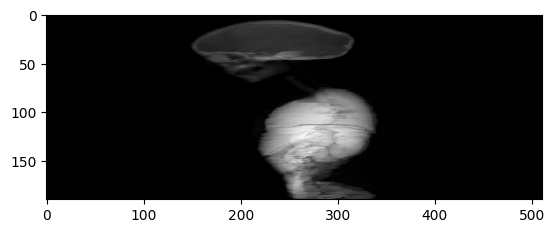

In [8]:
plt.imshow(phantom.sum(axis=2)[::-1], cmap='gray')

 Here is that lookup table mentioned above:

In [9]:
df = pd.read_csv("pediatric_phantom_data/labels.dat")
df

,Label,Organs
0,0,Air
1,1,Muscle
2,2,Bone
3,8,Stomach-Interior
4,21,Cartilage
5,38,Brain
6,226,Bladder
7,218,Gallbladder
8,180,Heart
9,222,Kidneys-right


 This is somewhat helpful for XCIST, since we need to eventually provide a list of materials in the phantom so that XCIST can look up their proper linear attenuation values for each X-ray energy in the simulation.

 However, we first need to make a dictionary connecting the labels in the lookup table to materials in the XCIST material library: https://github.com/xcist/main/tree/master/catsim/material

 We also eventually need to provide the approximate HU value for these materials. [Wikipedia has a simple table for this](https://en.wikipedia.org/wiki/Hounsfield_scale), I'm sure there are better resources, but it will do for this demo. Note also for some entries, e.g. Lung-left and Lung-right, we assign the same value, at least in this demo.

In [10]:
materials_dict = {
    'Air': ['air', -1000],
    'Muscle' : ['ICRU_muscle_adult', 55],
    'Bone' : ['CIRS_bone_10yo', 300],
    'Stomach-Interior': ['ncat_intestine', 10],
    'Cartilage': ['ncat_cartilage', 200],
    'Brain': ['ncat_brain', 45],
    'Bladder' : ['ncat_bladder', 15],
    'Gallbladder' : ['ncat_adipose', 15], #approximation, gall typicaller darker than liver
    'Heart' : ['ncat_heart', 55],
    'Kidneys-right' : ['ncat_kidney', 45],
    'Kidneys-left' : ['ncat_kidney', 45],
    'Small-Intestine' : ['ncat_intestine', 10],
    'Large-Intestine' : ['ncat_intestine', 10],
    'Liver' : ['ncat_liver', 60],
    'Lung-right' : ['ncat_lung', -700],
    'Lung-left' : ['ncat_lung', -700],
    'Pancreas' : ['ncat_pancreas', 40],
    'Spleen' : ['ncat_spleen', 50],
    'Stomach' : ['ncat_intestine', 55],
    'Thymus' : ['ncat_lymph', 10],
    'Eyes-right': ['ncat_water', 0],
    'Eyes-left': ['ncat_water', 0],
    'Skull': ['ncat_skull', 500],
    'Trachea': ['ncat_cartilage', 200]
}

 Using this dictionary we reassign the phantom voxels to the desired HU values (we haven't done CT yet, this is still an idealized phantom)

In [11]:
for material in df['Organs']:
  label = int(df[df['Organs'] == material]['Label'].iloc[0])
  phantom[phantom == label] = materials_dict[material][1]

 Looking at the projection again, it looks a bit more normal

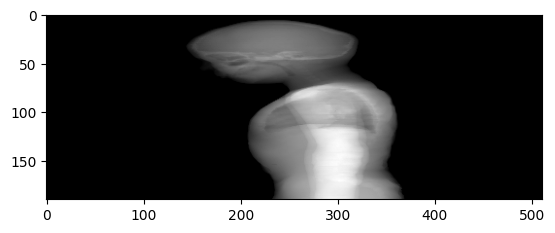

In [12]:
plt.imshow(phantom.sum(axis=2)[::-1], cmap='gray')

 In this demo we will limit ourselves to one slice to speed up computation time, you can select the `slice_idx` of interest below before moving on.

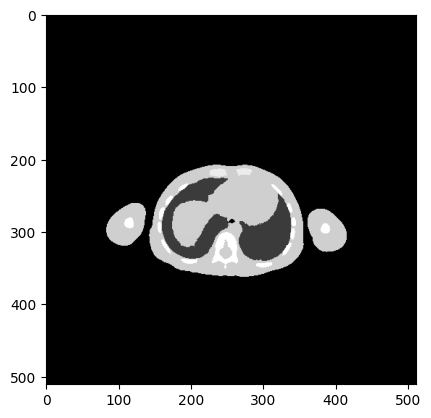

In [13]:
slice_idx = 75
img_slice = phantom[slice_idx]
plt.imshow(img_slice, cmap='gray')

 XCIST provides [examples](https://github.com/xcist/phantoms-voxelized/blob/main/DICOM_to_voxelized/DICOM_to_voxelized_phantom.py) of how to convert existing DICOM CT data into the proper format for running XCIST simulations. The script we'll use in this demo [](DICOM_to_voxelized_phantom.py) is a slight modification of the original, but still requires saving our ideal phantom slice(s) to DICOM first.

In [14]:
from pydicom import dcmread, dcmwrite
from pydicom.data import get_testdata_file
fpath = get_testdata_file("CT_small.dcm")
ds = dcmread(fpath)

 Rather than create new meta data from scratch we'll use the provided pydicom sample data, modify it and save it back out.

In [15]:
ds.Rows, ds.Columns = img_slice.shape
ds.PixelData = img_slice.tobytes()

In [16]:
from pathlib import Path
phantom_path = Path('pediatric_phantom_data')
sample_slice_dcm = phantom_path / f'sample_slice_{slice_idx:03d}.dcm'
dcmwrite(sample_slice_dcm, ds)

 Having too many materials will make the simulation run slowly, let's condense this list down to a few key materials

In [17]:
materials_dict.keys()

dict_keys(['Air', 'Muscle', 'Bone', 'Stomach-Interior', 'Cartilage', 'Brain', 'Bladder', 'Gallbladder', 'Heart', 'Kidneys-right', 'Kidneys-left', 'Small-Intestine', 'Large-Intestine', 'Liver', 'Lung-right', 'Lung-left', 'Pancreas', 'Spleen', 'Stomach', 'Thymus', 'Eyes-right', 'Eyes-left', 'Skull', 'Trachea'])

In [18]:
materials_to_keep = ['Air', 'Muscle', 'Bone', 'Lung-left']

In [19]:
materials = [materials_dict[m][0] for m in materials_dict if m in materials_to_keep]
thresholds = [materials_dict[m][1] for m in materials_dict if m in materials_to_keep]
materials, thresholds

(['air', 'ICRU_muscle_adult', 'CIRS_bone_10yo', 'ncat_lung'],
 [-1000, 55, 300, -700])

In [20]:
cfg_file_str = f"""
# Path where the DICOM images are located:
phantom.dicom_path = '{phantom_path}'
# Path where the phantom files are to be written (the last folder name will be the phantom files' base name):
phantom.phantom_path = '{phantom_path}/voxelized'
phantom.materials = {materials}
phantom.mu_energy = 63.948                  # Energy (keV) at which mu is to be calculated for all materials.
phantom.thresholds = {thresholds}		# Lower threshold (HU) for each material.
# phantom.slice_range = [[0,10]]			  # DICOM image numbers to include.
phantom.show_phantom = False                # Flag to turn on/off image display.
phantom.overwrite = True                   # Flag to overwrite existing files without warning.
"""

with open('dicom_to_voxelized.cfg', 'w') as f:
  f.write(cfg_file_str)

In [21]:
print(open('dicom_to_voxelized.cfg','r').read())


# Path where the DICOM images are located:
phantom.dicom_path = 'pediatric_phantom_data'
# Path where the phantom files are to be written (the last folder name will be the phantom files' base name):
phantom.phantom_path = 'pediatric_phantom_data/voxelized'
phantom.materials = ['air', 'ICRU_muscle_adult', 'CIRS_bone_10yo', 'ncat_lung']
phantom.mu_energy = 63.948                  # Energy (keV) at which mu is to be calculated for all materials.
phantom.thresholds = [-1000, 55, 300, -700]		# Lower threshold (HU) for each material.
# phantom.slice_range = [[0,10]]			  # DICOM image numbers to include.
phantom.show_phantom = False                # Flag to turn on/off image display.
phantom.overwrite = True                   # Flag to overwrite existing files without warning.



In [22]:
!git clone https://github.com/xcist/main.git XCIST
!pip install --upgrade --quiet XCIST/

fatal: destination path 'XCIST' already exists and is not an empty directory.


In [23]:
%run DICOM_to_voxelized_phantom.py dicom_to_voxelized.cfg

*
*********************************************
* DICOM dataset information:
* Patient age: 000Y, sex: O
* Scanner: GE MEDICAL SYSTEMS RHAPSODE
* Study date & desciption: 20040119, e+1
* Technique: 120 kVp, 170 mA
* Reconstruction: STANDARD kernel, 338.671600-mm FOV
* Image: 0.661468-mm pixels (XY), 5.000000-mm slices (Z)
*********************************************
*
*********************************************
* Segmentation parameters:
* Using thresholds specified in the config file.
* Materials: ['air', 'ncat_lung', 'ICRU_muscle_adult', 'CIRS_bone_10yo']
* mu values (/cm): [0.0, 0.05, 0.21, 0.38]
* mu(water) (/cm): 0.2
* Thresholds (/cm): [0.0, 0.21, 0.26, 0.06]
* Thresholds (HU): [-1000.0, 55.0, 300.0, -700.0]
*********************************************
* Calculating volume fraction maps for 4 materials and 1 slices...
* Writing volume fraction files for 4 materials and 1 slices, plus the HU data...
* Writing pediatric_phantom_data/voxelized/voxelized_air_512x511x1.raw...
* Wr

 ## Now We Run the CT Experiment

In [24]:
import catsim as xc
from pathlib import Path

In [25]:
phantom_path

PosixPath('pediatric_phantom_data')

In [26]:
cfg_path = Path('cfg')
cfg_path.mkdir(exist_ok=True)
with open(cfg_path / 'Phantom_male_infant_ref.cfg', 'w') as f:
  f.write(f"""
# Phantom
phantom.callback = "Phantom_Voxelized"      # name of function that reads and models phantom
phantom.projectorCallback = "C_Projector_Voxelized"  # name of function that performs projection through phantom
phantom.filename = "{phantom_path}/voxelized/voxelized.json"   # phantom filename
phantom.centerOffset = [0.0, 0.0, 0.0]      # offset of phantom center relative to origin (in mm)
phantom.scale = 1.0
""")

In [27]:
with open(cfg_path / 'Physics_Default.cfg', 'w') as f:
  f.write("""
# Geometric and energy sampling
physics.energyCount = 20
physics.monochromatic = -1  # -1 for polychromatic (see protocol.cfg); for monoenergetic specify the energy in keV
physics.colSampleCount = 2
physics.rowSampleCount = 2
physics.srcXSampleCount = 2
physics.srcYSampleCount = 2
physics.viewSampleCount = 2

# Flags to determine what has to be recalculated each view
physics.recalcDet = 0
physics.recalcSrc = 0
physics.recalcRayAngle = 0
physics.recalcSpec = 0
physics.recalcFilt = 0
physics.recalcFlux = 0
physics.recalcPht = 0
physics.recalcDet = 0

# Noise on/off settings
physics.enableQuantumNoise = 1
physics.enableElectronicNoise = 1

# Internal physics models
physics.rayAngleCallback = "Detector_RayAngles_2D"
physics.fluxCallback = "Detection_Flux"
physics.scatterCallback = ""
physics.scatterKernelCallback = ""
physics.scatterScaleFactor = 1
physics.prefilterCallback = "Detection_prefilter"
physics.crosstalkCallback = ""
physics.lagCallback = ""
physics.opticalCrosstalkCallback = ""
physics.DASCallback = "Detection_DAS"

# I/O preferences
physics.outputCallback = "WriteRawView"
""")

In [28]:
with open(cfg_path / 'Protocol_Default.cfg', 'w') as f:
  f.write("""
protocol.scanTypes = [1, 1, 1]              # flags for airscan, offset scan, phantom scan

# Table and gantry
protocol.scanTrajectory = "Gantry_Helical"  # name of the function that defines the scanning trajectory and model
protocol.viewsPerRotation = 1000            # total numbers of view per rotation
protocol.viewCount = 1000                   # total number of views in scan
protocol.startViewId = 0                    # index of the first view in the scan
protocol.stopViewId = protocol.startViewId+protocol.viewCount-1 # index of the last view in the scan
protocol.airViewCount = 1                   # number of views averaged for air scan
protocol.offsetViewCount = 1                # number of views averaged for offset scan
protocol.rotationTime = 1.0                 # gantry rotation period (in seconds)
protocol.rotationDirection = 1              # gantry rotation direction (1=CW, -1 CCW, seen from table foot-end)
protocol.startAngle = 0                     # relative to vertical y-axis (n degrees)
protocol.tableSpeed = 0                     # speed of table translation along positive z-axis (in mm/sec)
protocol.startZ = 0                         # start z-position of table
protocol.tiltAngle = 0                      # gantry tilt angle towards negative z-axis (in degrees)
protocol.wobbleDistance = 0.0               # focalspot wobble distance
protocol.focalspotOffset = [0, 0, 0]        # focalspot position offset

# X-ray tube technique and filtration
protocol.mA = 200                           # tube current (in mA)
protocol.spectrumCallback = "Spectrum"      # name of function that reads and models the X-ray spectrum
protocol.spectrumFilename = "tungsten_tar7_120_unfilt.dat" # name of the spectrum file
protocol.spectrumScaling = 1                # scaling factor, works for both mono- and poly-chromatic spectra
protocol.spectrumUnit_mm = 0;               # Is the spectrum file in units of photons/sec/mm^2/<current>?
protocol.spectrumUnit_mA = 1;               # Is the spectrum file in units of photons/sec/<area>/mA?
protocol.bowtie = "small.txt"               # name of the bowtie file (or [] for no bowtie)
protocol.filterCallback = "Xray_Filter"     # name of function to compute additional filtration
protocol.flatFilter = ['Al',3.0]            # additional filtration - materials and thicknesses (in mm)
protocol.dutyRatio = 1.0                    # tube ON time fraction (for pulsed tubes)

# Pre- and Post-log processes
protocol.maxPrep = 9                        # set the upper limit of prep, can be used for simple low signal correction
""")

In [29]:
with open(cfg_path / 'Recon_Default.cfg', 'w') as f:
  f.write("""
recon.fov = 250.0                       # diameter of the reconstruction field-of-view (in mm)
recon.imageSize = 512                   # number of columns and rows to be reconstructed (square)
recon.sliceCount = 1                    # number of slices to reconstruct
recon.sliceThickness = 1.0              # reconstruction slice thickness AND inter-slice interval (in mm)
recon.centerOffset = [0.0, 0.0, 0.0]    # reconstruction offset relative to center of rotation (in mm)
recon.reconType = 'fdk_equiAngle'       # Name of the recon function to call
recon.kernelType = 'S-L'           # 'R-L' for the Ramachandran-Lakshminarayanan (R-L) filter, rectangular window function
                                        # 'S-L' for the Shepp-Logan (S-L) filter, sinc window function
                                        # 'Soft', 'Standard', 'Bone' for kernels similar to those on clinical scanners

recon.do_Recon = True
recon.startAngle = 0                    # in degrees; 0 is with the X-ray source at the top
recon.unit = 'HU'                       # '/mm', '/cm', or 'HU'
recon.mu = 0.02059                        # in /mm; typically around 0.02/mm
recon.huOffset = -1000                  # unit is HU, -1000 HU by definition but sometimes something else is preferable
recon.printReconParameters = False      # Flag to print the recon parameters
recon.saveImageVolume = True            # Flag to save recon results as one big file
recon.saveSingleImages = False          # Flag to save recon results as individual imagesrecon.printReconParameters = False      # Flag to print the recon parameters
recon.displayImagePictures = True       # Flag to display the recon results as .png images
recon.saveImagePictureFiles = False     # Flag to save the recon results as .png images
recon.displayImagePictureAxes = False   # Flag to display the axes on the .png images
recon.displayImagePictureTitles = False # Flag to display the titles on the .png images
""")

In [30]:
with open(cfg_path / 'Scanner_Default', 'w') as f:
  f.write("""
# Scanner geometry
scanner.detectorCallback = "Detector_ThirdgenCurved" # name of function that defines the detector shape and model
scanner.sid = 540.0                         # source-to-iso distance (in mm)
scanner.sdd = 950.0                         # source-to-detector distance (in mm)
scanner.detectorColsPerMod = 1              # number of detector columns per module
scanner.detectorRowsPerMod = 16             # number of detector rows per module
scanner.detectorColOffset = 0.0             # detector column offset relative to centered position (in detector columns)
scanner.detectorRowOffset = 0.0             # detector row offset relative to centered position (in detector rows)
scanner.detectorColSize = 1.0               # detector column pitch or size (in mm)
scanner.detectorRowSize = 1.0               # detector row pitch or size (in mm)
scanner.detectorColCount = 900              # total number of detector columns
scanner.detectorRowCount = scanner.detectorRowsPerMod     # total number of detector rows
scanner.detectorPrefilter = ['graphite', 1.0]  # detector filter

# X-ray tube
scanner.focalspotCallback = "SetFocalspot"  # name of function that defines the focal spot shape and model
scanner.focalspotShape = "Uniform"          # Parameterize the model
scanner.targetAngle = 7.0                   # target angle relative to scanner XY-plane (in degrees)
scanner.focalspotWidth = 1.0
scanner.focalspotLength = 1.0

# Detector
scanner.detectorMaterial = "Lumex"          # detector sensor material
scanner.detectorDepth = 3.0                 # detector sensor depth (in mm)
scanner.detectionCallback = "Detection_EI"  # name of function that defines the detection process (conversion from X-rays to detector signal)
scanner.detectionGain = 17.0                # factor to convert energy to electrons (electrons / keV)
scanner.detectorColFillFraction = 0.9       # active fraction of each detector cell in the column direction
scanner.detectorRowFillFraction = 0.9       # active fraction of each detector cell in the row direction
scanner.eNoise = 3500.0                     # standard deviation of Gaussian electronic noise (in electrons)
""")

In [31]:
ct = xc.CatSim('cfg/Phantom_male_infant_ref',
               'cfg/Physics_Default',
               'cfg/Protocol_Default',
               'cfg/Recon_Default',
               'cfg/Scanner_Default')

In [32]:
ct.resultsName = 'male_infant_test'
ct.cfg.experimentDirectory = 'male_infant_test'
ct.cfg.waitForKeypress=False

In [33]:
ct.run_all()

Airscan
Scan sim time: 0.7 s
Offset scan
Scan sim time: 0.1 s
Phantom scan
in C> Preparing to allocate memory for material volume data...
in C> Allocated memory for image volume for material  1
in C> Copying data for material  1 into C memory...in C>  done.
in C> Allocated memory for image volume for material  2
in C> Copying data for material  2 into C memory...in C>  done.
in C> Allocated memory for image volume for material  3
in C> Copying data for material  3 into C memory...in C>  done.
in C> Allocated memory for image volume for material  4
in C> Copying data for material  4 into C memory...in C>  done.
in C> Allocated a total of      3 MB.
phantom scan view loop...


100%|██████████| 1000/1000 [05:44<00:00,  2.90it/s]


Scan sim time: 344.7 s
Prep view
Simulation is done


 Any parameters can also be modified "on the fly" by modifying the configuration object `cfg`:

## Let's Look at the outputs

The `.prep` file is the "Preprocessed" sinogram, inspecting its size we see that it's dimensions are in view angle, detector rows (z-direction), detector columns (x-direction), see the diagram for context.

![](CT_diagram.png)

In [34]:
prep = xc.rawread(ct.resultsName+'.prep', [ct.protocol.viewCount, ct.scanner.detectorRowCount, ct.scanner.detectorColCount], 'float')
prep.shape

(1000, 16, 900)

This multi-row detector scanner is configured with 16 rows of detectors in the Z direction, 900 columns of detectors in the X direction, and this particular scan consisted of 1000 projections taken in one rotation. This should all be consistent with the parameters set in the configuration files.

A common way of looking at CT projection data is as a sinogram, looking at one detector row and plotting the detector columns against view angle like so

Text(0, 0.5, 'View Index')

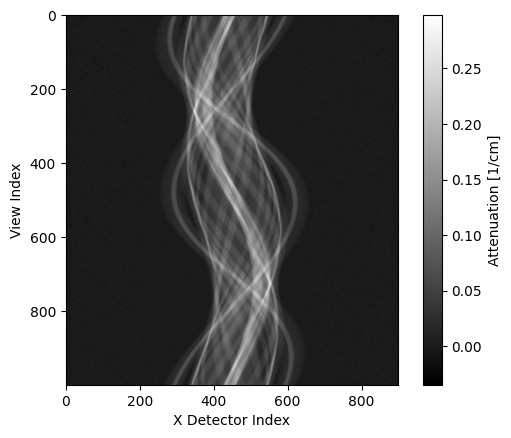

In [35]:
row_idx = 5
pos = plt.imshow(prep[:,row_idx, :], cmap='gray')
plt.colorbar(pos,label='Attenuation [1/cm]')
plt.xlabel("X Detector Index")
plt.ylabel("View Index")

Note that you can also look at the whole detector output (all rows and detectors) for a given view angle, but the aspect ratio makes it harder to decipher since there are typically far more columns than rows in most CT scanners

Text(0, 0.5, 'Z Detector Index')

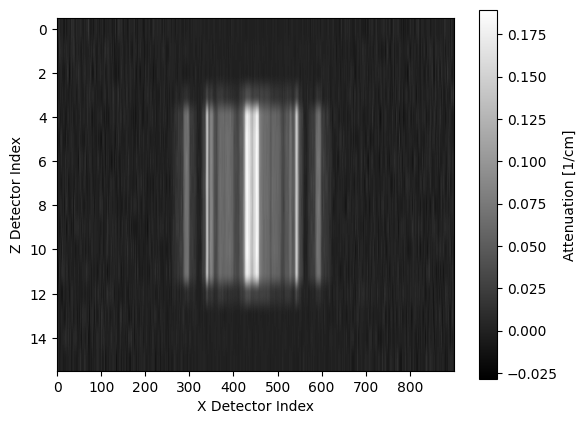

In [36]:
view_idx = 0
pos = plt.imshow(prep[view_idx,:, :], cmap='gray', aspect=50)
plt.colorbar(pos,label='Attenuation [1/cm]')
plt.xlabel("X Detector Index")
plt.ylabel("Z Detector Index")

In practice there are many (often secret) steps involved in generating this preprocessed sinogram. In this simplified demo using XCIST other raw outputs are given that are used to ultimately compute the preprocessed sinogram. The first is the `.scan` files, this is XCIST's version of the "raw" projection data off the scanner, let's look at it.

Text(0, 0.5, 'View Index')

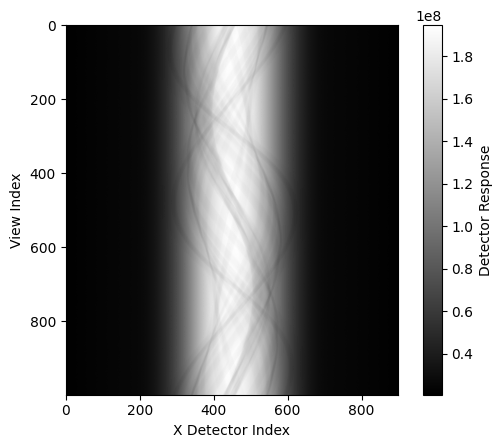

In [37]:
raw_projections = xc.rawread(ct.resultsName+'.scan', [ct.protocol.viewCount, ct.scanner.detectorRowCount, ct.scanner.detectorColCount], 'float')
row_idx = 5
pos = plt.imshow(raw_projections[:,row_idx, :], cmap='gray')
plt.colorbar(pos,label='Detector Response')
plt.xlabel("X Detector Index")
plt.ylabel("View Index")

In the raw data view, pixel values refer to the received x-ray intensity. Note the brightness in the center and darkness at the edges, this is due to the bowtie filter (see diagram above) which is a dose reduction technique commonly used in CT scanners. The `.air` image, this is a single view projection using the whole detector array so its size is (900 detectors, 16 rows), and clearly shows the bowtie's effects

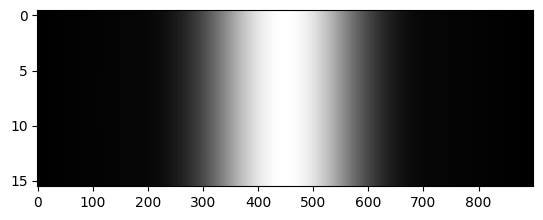

In [38]:
air = xc.rawread(ct.resultsName+'.air', [ct.scanner.detectorRowCount, ct.scanner.detectorColCount], 'float')
plt.imshow(air, cmap='gray', aspect=20)

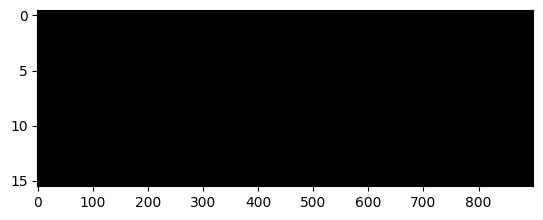

In [39]:
offset = xc.rawread(ct.resultsName+'.offset', [ct.scanner.detectorRowCount, ct.scanner.detectorColCount], 'float')
plt.imshow(offset, cmap='gray', aspect=20)

In [40]:
offset.max()

0.0

## Image Reconstruction

In [41]:
import reconstruction.pyfiles.recon as recon

In [42]:
ct.cfg.recon.displayImagePictures = True
ct.cfg.waitForKeypress=False
ct.cfg.do_Recon = True

* Loading the projection data...
* Pre-weighting the filter...
* Applying the filter...
* Running the reconstruction...
* Converting projection data from a numpy array to a C array...
* Allocating a C array for the recon results...
* In C...
* Converting the recon results from a C array to a numpy array...
* Scaling recon data...
* Writing the recon results to one big file...


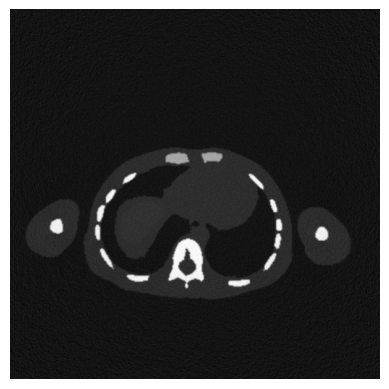

In [43]:

ct.cfg.recon.fov = 250
recon.recon(ct.cfg)